In [1]:
import torch
import monai
import numpy as np
import nibabel as nib
from glob import glob
from matplotlib import pyplot as plt

from monai.transforms import (
    Activations,
    AsChannelFirstD,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized
)

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, decollate_batch


from torch.utils.tensorboard import SummaryWriter


In [2]:
#loading volume paths
LOCATION = 'scan' #laptop
if LOCATION == 'scan':
    isles_data_root = '/str/data/ASAP/miccai22_data/isles/centralized/'
if LOCATION == 'laptop':
    isles_data_root = '/data/ASAP/miccai22_data/isles/centralized/'

cbf_paths_train  = sorted(glob(isles_data_root+'/train/'+'/**/*CBF*/*.nii'))
tmax_paths_train = sorted(glob(isles_data_root+'/train/'+'/**/*Tmax*/*.nii'))
lbl_paths_train = sorted(glob(isles_data_root+'/train/'+'/**/*OT*/*nii'))


cbf_paths_valid  = sorted(glob(isles_data_root+'/valid/'+'/**/*CBF*/*.nii'))
tmax_paths_valid = sorted(glob(isles_data_root+'/valid/'+'/**/*Tmax*/*.nii'))
lbl_paths_valid = sorted(glob(isles_data_root+'/valid/'+'/**/*OT*/*nii'))


cbf_paths_test  = sorted(glob(isles_data_root+'/test/'+'/**/*CBF*/*.nii'))
tmax_paths_test = sorted(glob(isles_data_root+'/test/'+'/**/*Tmax*/*.nii'))
lbl_paths_test = sorted(glob(isles_data_root+'/test/'+'/**/*OT*/*nii'))

print(len(cbf_paths_train), len(tmax_paths_train), len(lbl_paths_train))
print(len(cbf_paths_valid), len(tmax_paths_valid), len(lbl_paths_valid))
print(len(cbf_paths_test), len(tmax_paths_test), len(lbl_paths_test))

66 66 66
13 13 13
15 15 15


In [3]:
#creating the dataloader for 10 ISLES volumes using the T_max and the CBF
#For cbf we are windowing 1-1024
#For tmax we'll window 0-60
imtrans = Compose(
    [   LoadImage(image_only=True),
        ScaleIntensity(minv=0.0, maxv=1200),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)


In [52]:
imtrans_test = Compose(
    [   LoadImage(image_only=True),
        ScaleIntensity(minv=0.0, maxv=1200),
        AddChannel(),
        #RandSpatialCrop((224, 224,1), random_size=False), In test we would like to process ALL slices
        EnsureType(),
        #Resized
    ]
)

segtrans_test = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        #RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)


In [4]:
cbf_paths_train

['/str/data/ASAP/miccai22_data/isles/centralized//train/case_1/SMIR.Brain.XX.O.CT_CBF.345563/SMIR.Brain.XX.O.CT_CBF.345563.nii',
 '/str/data/ASAP/miccai22_data/isles/centralized//train/case_10/SMIR.Brain.XX.O.CT_CBF.345626/SMIR.Brain.XX.O.CT_CBF.345626.nii',
 '/str/data/ASAP/miccai22_data/isles/centralized//train/case_11/SMIR.Brain.XX.O.CT_CBF.345633/SMIR.Brain.XX.O.CT_CBF.345633.nii',
 '/str/data/ASAP/miccai22_data/isles/centralized//train/case_12/SMIR.Brain.XX.O.CT_CBF.345640/SMIR.Brain.XX.O.CT_CBF.345640.nii',
 '/str/data/ASAP/miccai22_data/isles/centralized//train/case_13/SMIR.Brain.XX.O.CT_CBF.345647/SMIR.Brain.XX.O.CT_CBF.345647.nii',
 '/str/data/ASAP/miccai22_data/isles/centralized//train/case_14/SMIR.Brain.XX.O.CT_CBF.345654/SMIR.Brain.XX.O.CT_CBF.345654.nii',
 '/str/data/ASAP/miccai22_data/isles/centralized//train/case_15/SMIR.Brain.XX.O.CT_CBF.345661/SMIR.Brain.XX.O.CT_CBF.345661.nii',
 '/str/data/ASAP/miccai22_data/isles/centralized//train/case_2/SMIR.Brain.XX.O.CT_CBF.34557

In [53]:
ds_train = ArrayDataset(cbf_paths_train, imtrans, lbl_paths_train, segtrans)
train_loader   = torch.utils.data.DataLoader(
    ds_train, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

ds_valid = ArrayDataset(cbf_paths_valid, imtrans, lbl_paths_valid, segtrans)
valid_loader   = torch.utils.data.DataLoader(
    ds_valid, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

ds_test = ArrayDataset(cbf_paths_test, imtrans_test, lbl_paths_test, segtrans_test)
test_loader   = torch.utils.data.DataLoader(
    ds_test, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)

im, seg = first(train_loader)
print(im.shape, seg.shape)
print(np.histogram(seg[0,0,:,:,0]))
print(im.max())

torch.Size([1, 1, 224, 224, 1]) torch.Size([1, 1, 224, 224, 1])
(array([49852,     0,     0,     0,     0,     0,     0,     0,     0,
         324]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
tensor(584.4746)


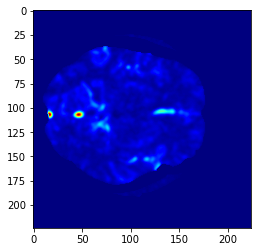

In [6]:
plt.imshow(im[0,0,:,:,0],cmap='jet')

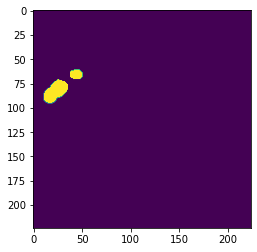

In [7]:
plt.imshow(seg[0,0,:,:,0])

In [8]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

In [9]:
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    kernel_size = (3,3),
    #dropout = 0.2,
    num_res_units=2,
).to(device)


In [12]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [13]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

In [104]:
batch_data = next(iter(train_loader))
batch_data[0].shape

torch.Size([1, 1, 224, 224, 1])

In [105]:
torch.swapaxes(batch_data[0][0], 1, -1).shape

torch.Size([1, 1, 224, 224])

In [14]:
batch_data = next(iter(train_loader))
inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
print(inputs.shape,labels.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [15]:
model.train()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [16]:
#Testing that the model works in one iteration
optimizer.zero_grad()
outputs = model(inputs)
loss = loss_function(outputs, labels)
loss.backward()
optimizer.step()

In [17]:
for epoch in range(400):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{400}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #Swaping axes to have a batch of Batch_size, Channels, width and height
        inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_loader) // train_loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    torch.save(model.state_dict(), "metric_model_segmentation2d_array_ep_"+str(epoch)+".pth")
    writer.add_scalar("average loss", epoch_loss, epoch + 1)
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in valid_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (128, 128)
                sw_batch_size = 1
                val_outputs = model(val_images[:,:,:,:,0])
                val_outputs = val_outputs>0.5 #This assumes one slice in the last dim
                #val_outputs = [sliding_window_inference(val_images[:,:,:,:,i], roi_size, sw_batch_size, model) for i in range(val_images.shape[-1])]
                #val_outputs = torch.stack(val_outputs,dim=4)
                #val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels[:,:,:,:,0])
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
    

----------
epoch 1/400
epoch 1 average loss: 0.9589
----------
epoch 2/400
epoch 2 average loss: 0.9455
saved new best metric model
current epoch: 2 current mean dice: 0.1743 best mean dice: 0.1743 at epoch 2
----------
epoch 3/400
epoch 3 average loss: 0.9370
----------
epoch 4/400
epoch 4 average loss: 0.9308
saved new best metric model
current epoch: 4 current mean dice: 0.2169 best mean dice: 0.2169 at epoch 4
----------
epoch 5/400
epoch 5 average loss: 0.9227
----------
epoch 6/400
epoch 6 average loss: 0.9142
saved new best metric model
current epoch: 6 current mean dice: 0.2774 best mean dice: 0.2774 at epoch 6
----------
epoch 7/400
epoch 7 average loss: 0.9073
----------
epoch 8/400
epoch 8 average loss: 0.9002
current epoch: 8 current mean dice: 0.2060 best mean dice: 0.2774 at epoch 6
----------
epoch 9/400
epoch 9 average loss: 0.8870
----------
epoch 10/400
epoch 10 average loss: 0.8803
current epoch: 10 current mean dice: 0.2490 best mean dice: 0.2774 at epoch 6
--------

epoch 87 average loss: 0.4104
----------
epoch 88/400
epoch 88 average loss: 0.4168
current epoch: 88 current mean dice: 0.3248 best mean dice: 0.4530 at epoch 26
----------
epoch 89/400
epoch 89 average loss: 0.3975
----------
epoch 90/400
epoch 90 average loss: 0.4204
current epoch: 90 current mean dice: 0.3871 best mean dice: 0.4530 at epoch 26
----------
epoch 91/400
epoch 91 average loss: 0.4138
----------
epoch 92/400
epoch 92 average loss: 0.4009
current epoch: 92 current mean dice: 0.3707 best mean dice: 0.4530 at epoch 26
----------
epoch 93/400
epoch 93 average loss: 0.4055
----------
epoch 94/400
epoch 94 average loss: 0.6056
current epoch: 94 current mean dice: 0.0704 best mean dice: 0.4530 at epoch 26
----------
epoch 95/400
epoch 95 average loss: 0.8523
----------
epoch 96/400
epoch 96 average loss: 0.7415
current epoch: 96 current mean dice: 0.3778 best mean dice: 0.4530 at epoch 26
----------
epoch 97/400
epoch 97 average loss: 0.6836
----------
epoch 98/400
epoch 98 av

epoch 173 average loss: 0.3789
----------
epoch 174/400
epoch 174 average loss: 0.3892
current epoch: 174 current mean dice: 0.2848 best mean dice: 0.4548 at epoch 100
----------
epoch 175/400
epoch 175 average loss: 0.3635
----------
epoch 176/400
epoch 176 average loss: 0.3611
current epoch: 176 current mean dice: 0.2562 best mean dice: 0.4548 at epoch 100
----------
epoch 177/400
epoch 177 average loss: 0.3544
----------
epoch 178/400
epoch 178 average loss: 0.3591
current epoch: 178 current mean dice: 0.2781 best mean dice: 0.4548 at epoch 100
----------
epoch 179/400
epoch 179 average loss: 0.3562
----------
epoch 180/400
epoch 180 average loss: 0.3513
current epoch: 180 current mean dice: 0.3797 best mean dice: 0.4548 at epoch 100
----------
epoch 181/400
epoch 181 average loss: 0.3465
----------
epoch 182/400
epoch 182 average loss: 0.3474
current epoch: 182 current mean dice: 0.3445 best mean dice: 0.4548 at epoch 100
----------
epoch 183/400
epoch 183 average loss: 0.3594
----

current epoch: 258 current mean dice: 0.2506 best mean dice: 0.4548 at epoch 100
----------
epoch 259/400
epoch 259 average loss: 0.3081
----------
epoch 260/400
epoch 260 average loss: 0.3042
current epoch: 260 current mean dice: 0.2212 best mean dice: 0.4548 at epoch 100
----------
epoch 261/400
epoch 261 average loss: 0.3117
----------
epoch 262/400
epoch 262 average loss: 0.3080
current epoch: 262 current mean dice: 0.2919 best mean dice: 0.4548 at epoch 100
----------
epoch 263/400
epoch 263 average loss: 0.2994
----------
epoch 264/400
epoch 264 average loss: 0.3001
current epoch: 264 current mean dice: 0.2784 best mean dice: 0.4548 at epoch 100
----------
epoch 265/400
epoch 265 average loss: 0.2985
----------
epoch 266/400
epoch 266 average loss: 0.3004
current epoch: 266 current mean dice: 0.2489 best mean dice: 0.4548 at epoch 100
----------
epoch 267/400
epoch 267 average loss: 0.3006
----------
epoch 268/400
epoch 268 average loss: 0.2974
current epoch: 268 current mean dic

epoch 343 average loss: 0.2999
----------
epoch 344/400
epoch 344 average loss: 0.2958
current epoch: 344 current mean dice: 0.3275 best mean dice: 0.4548 at epoch 100
----------
epoch 345/400
epoch 345 average loss: 0.2903
----------
epoch 346/400
epoch 346 average loss: 0.2883
current epoch: 346 current mean dice: 0.2274 best mean dice: 0.4548 at epoch 100
----------
epoch 347/400
epoch 347 average loss: 0.2881
----------
epoch 348/400
epoch 348 average loss: 0.3011
current epoch: 348 current mean dice: 0.2475 best mean dice: 0.4548 at epoch 100
----------
epoch 349/400
epoch 349 average loss: 0.2926
----------
epoch 350/400
epoch 350 average loss: 0.2894
current epoch: 350 current mean dice: 0.2167 best mean dice: 0.4548 at epoch 100
----------
epoch 351/400
epoch 351 average loss: 0.2898
----------
epoch 352/400
epoch 352 average loss: 0.2913
current epoch: 352 current mean dice: 0.3593 best mean dice: 0.4548 at epoch 100
----------
epoch 353/400
epoch 353 average loss: 0.2948
----

In [29]:
inputs.shape

torch.Size([1, 1, 224, 224])

In [31]:
print(val_labels.shape, val_outputs.shape)

torch.Size([1, 1, 224, 224, 1]) torch.Size([1, 1, 224, 224])


In [30]:
val_images.shape

torch.Size([1, 1, 224, 224, 1])

In [22]:
val_images.shape

torch.Size([1, 1, 224, 224, 1])

In [90]:
print(outputs.shape, labels.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [25]:
dice_metric.reset()
pred_slice = np.array(outputs[0,0,:,:].cpu().detach().numpy()>0.5,dtype='uint8')
label_slice= labels[0,0,0:,:].cpu().detach().numpy()
dice_metric(y_pred=outputs>0.5, y=labels)


tensor([[0.9934]], device='cuda:0')

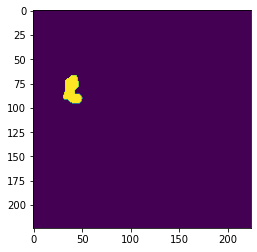

In [26]:
plt.imshow(outputs[0,0,:,:].cpu().detach().numpy()>0.5)

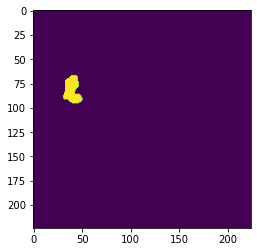

In [27]:
plt.imshow(labels[0,0,0:,:].cpu().detach().numpy())

In [18]:
for ep in range(400):
    cur_checkpoint_path = '/home/otarola/miccai22/metric_model_segmentation2d_array_ep_'+str(ep)+'.pth'

    checkpoint = torch.load(cur_checkpoint_path)

    model.load_state_dict(checkpoint)
    outputs = model(inputs)

    cur_save_img_path = '/home/otalora/'+cur_checkpoint_path.split('/')[-1] + '.png'
    pp = np.array(outputs[0,0,:,:].cpu().detach().numpy()>0.5,dtype='uint8')
    plt.imsave(cur_save_img_path, pp)
    print(cur_save_img_path)

/home/otalora/metric_model_segmentation2d_array_ep_0.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_1.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_2.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_3.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_4.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_5.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_6.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_7.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_8.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_9.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_10.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_11.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_12.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_13.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_14.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_15.pth.png
/home/otalora/metr

/home/otalora/metric_model_segmentation2d_array_ep_144.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_145.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_146.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_147.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_148.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_149.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_150.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_151.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_152.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_153.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_154.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_155.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_156.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_157.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_158.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_159.

/home/otalora/metric_model_segmentation2d_array_ep_281.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_282.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_283.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_284.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_285.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_286.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_287.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_288.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_289.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_290.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_291.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_292.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_293.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_294.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_295.pth.png
/home/otalora/metric_model_segmentation2d_array_ep_296.

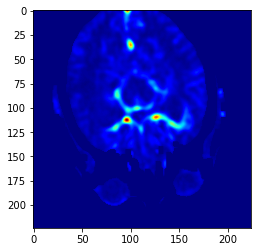

In [29]:
plt.imshow(inputs[0,0,:,:].cpu().detach().numpy(),cmap='jet')

## Testing the best validation model in an unseen test volume (slice-wise)

In [ ]:
#Loading a test model


In [190]:
ep= 100
cur_checkpoint_path = '/home/otarola/miccai22/metric_model_segmentation2d_array_ep_'+str(ep)+'.pth'

checkpoint = torch.load('/home/otarola/miccai22/best_metric_model_segmentation2d_array.pth')

model.load_state_dict(checkpoint)
outputs = model(inputs)

cur_save_img_path = '/home/otalora/'+cur_checkpoint_path.split('/')[-1] + '.png'
pp = np.array(outputs[0,0,:,:].cpu().detach().numpy()>0.5,dtype='uint8')


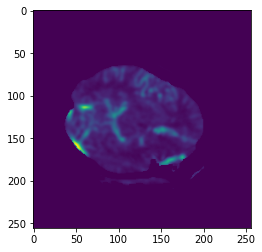

In [191]:
plt.imshow(ds_test[0][0][0,:,:,0])

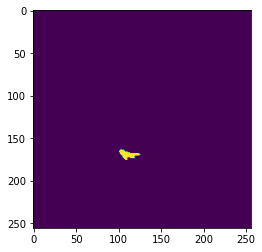

In [91]:
plt.imshow(ds_test[0][1][0,:,:,0])

In [197]:
count_volume = 0
dice_metric.reset()
metric_values_test = []
for test_data in test_loader:
    count_volume = count_volume+1
    cur_image, cur_label = test_data
    cur_outputs = []
    cur_labels  = []
    labels   = torch.tensor(cur_label).to(device)
    for ct_slice in range(cur_image.shape[-1]):
        cur_ct_slice = torch.tensor(cur_image[:,:,:,:,ct_slice]).to(device)        
        label    = labels[:,:,:,:,ct_slice]
        outputs = model(cur_ct_slice)
        dice_metric(y_pred=outputs, y=label)

        cur_outputs.append(outputs.cpu().detach().numpy()>0.5)
        cur_labels.append(label.cpu().detach().numpy()>0.5)
        #cur_save_img_path = '/home/otalora/'+cur_checkpoint_path.split('/')[-1] + '.png'
        #pp = np.array(outputs[0,0,:,:].cpu().detach().numpy()>0.5,dtype='uint8')
    cur_outputs = np.array(cur_outputs).squeeze()#.reshape(1,1,256,256,cur_image.shape[-1])#.squeeze()
    cur_labels  = np.array(cur_labels).squeeze()

    for i in range(cur_outputs.shape[0]):
        
        cur_save_img_path = '/home/otalora/miccai22/test_predictions/'+str(count_volume)+'_'+str(i) +'_img.png'
        cur_save_out_path = '/home/otalora/miccai22/test_predictions/'+str(count_volume)+'_'+str(i) +'_out.png'
        cur_save_lbl_path = '/home/otalora/miccai22/test_predictions/'+str(count_volume)+'_'+str(i) +'_lbl.png'
       
        plt.imsave(cur_save_img_path, cur_image[0,0,:,:,i].cpu().detach().numpy(),cmap='jet')
        plt.imsave(cur_save_out_path, cur_outputs[i,:,:])
        plt.imsave(cur_save_lbl_path, cur_labels[i,:,:])
    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    metric_values_test.append(metric)
print("AVG TEST DICE SCORE: " + str(np.mean(metric_values)) + " - STD: " + str(np.std(metric_values)))

/tmp/ipykernel_157550/171815966.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels   = torch.tensor(cur_label).to(device)
/tmp/ipykernel_157550/171815966.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cur_ct_slice = torch.tensor(cur_image[:,:,:,:,ct_slice]).to(device)


AVG TEST DICE SCORE: 0.30477230839089314 - STD: 0.07908895121739258


In [150]:
cur_label.shape

torch.Size([1, 1, 256, 256, 16])

In [152]:
print(cur_outputs.shape)
print(cur_labels.shape)

(16, 256, 256)
(16, 256, 256)


In [129]:
cur_image[:,:,:,ct_slice].shape

torch.Size([1, 1, 256, 16])

In [173]:
cur_ct_slice.shape

torch.Size([1, 1, 256, 256])

In [ ]:

model.load_state_dict(checkpoint)
outputs = model(inputs)

cur_save_img_path = '/home/otalora/'+cur_checkpoint_path.split('/')[-1] + '.png'
pp = np.array(outputs[0,0,:,:].cpu().detach().numpy()>0.5,dtype='uint8')
plt.imsave(cur_save_img_path, pp)


In [198]:
ds_test[-1][0].shape

torch.Size([1, 256, 256, 16])

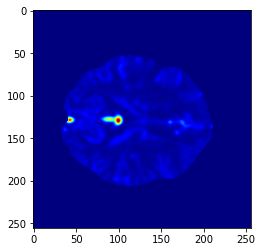

In [199]:
plt.imshow(ds_test[-1][0][0,:,:,8].cpu().detach().numpy(),cmap='jet')

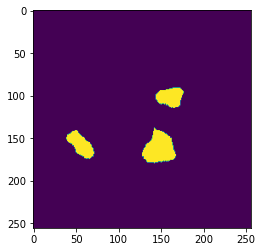

In [200]:
plt.imshow(cur_outputs[8,:,:])

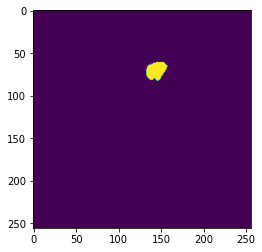

In [201]:
plt.imshow(cur_labels[8,:,:])

In [134]:
cur_labels.shape

(16, 256, 256, 16)

In [76]:
outputs.cpu().detach().numpy()>0.5

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]])

In [202]:
for test_data in test_loader:
    print(test_data[0].shape)

torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 2])
torch.Size([1, 1, 256, 256, 22])
torch.Size([1, 1, 256, 256, 16])
torch.Size([1, 1, 256, 256, 16])
